# 3. 下游分析1

In [2]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

Global seed set to 0
/usr/local/conda/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovgi/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 读取数据

In [4]:
# 红系成熟部分
adata_filename = "./data/gastrulation.h5ad"

adata = scv.read(adata_filename)
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 500 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [5]:
adata_bak = adata.copy()

## 2. 其他批次结果整合的结果对比

In [6]:
adata_review = scv.read("./data/gastrulation_review.h5ad")
adata_latentvelo = scv.read("./data/gastrulation_latentvelo.h5ad")

scv.tl.velocity(adata_review)
scv.tl.velocity_graph(adata_review)

scv.tl.velocity(adata_latentvelo)
scv.tl.velocity_graph(adata_latentvelo)

adata_review, adata_latentvelo

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


(AnnData object with n_obs × n_vars = 500 × 2000
     obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
     uns: 'celltype_colors', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
     obsm: 'X_pca', 'X_umap'
     layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity', 'variance_velocity'
     obsp: 'connectiv

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


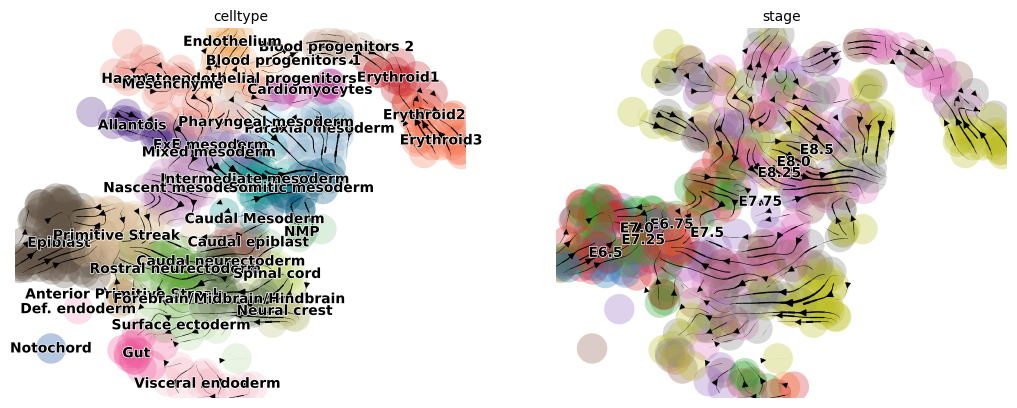

In [7]:
adata = velovgi.tl.read_adata("./data/adata/") # 后续的绘图都是在这个处理后的adata上做的
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key]) # 添加批次的颜色
adata_review.uns["%s_colors"%batch_key] = adata.uns["%s_colors"%batch_key]
adata_latentvelo.uns["%s_colors"%batch_key] = adata.uns["%s_colors"%batch_key]

1. 可视化对比，只能恢复一些局部的分化方向，而无法恢复全局

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Axes: title={'center': 'velovgi'}>

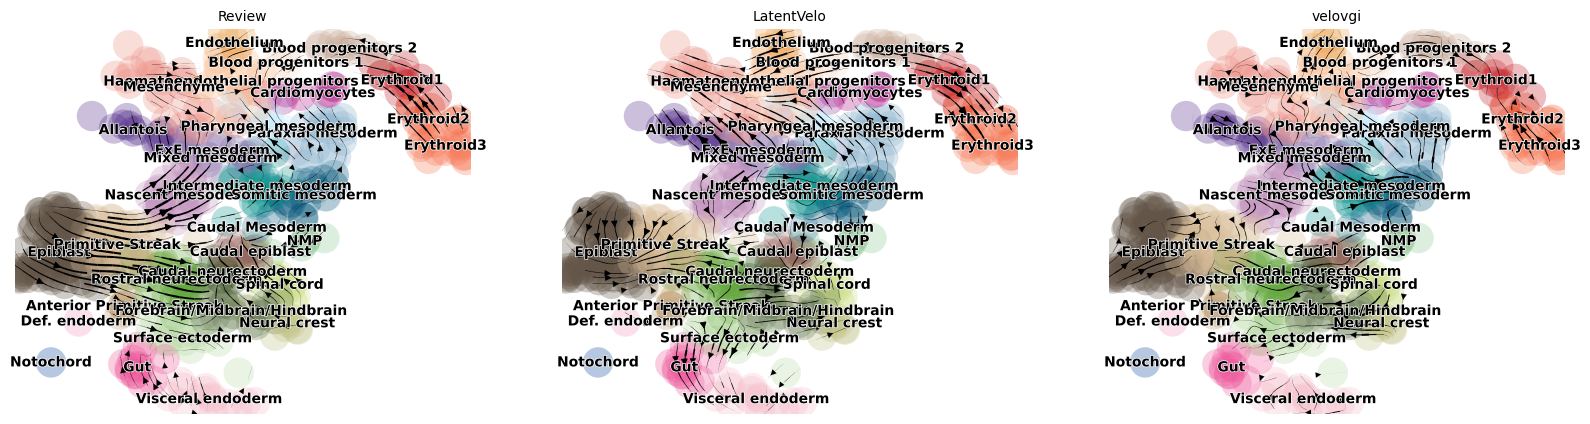

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(20,5))
scv.pl.velocity_embedding_stream(adata_review, color=cluster_key, title="Review", ax=ax[0], show=False)
scv.pl.velocity_embedding_stream(adata_latentvelo, color=cluster_key, title="LatentVelo", ax=ax[1], show=False)
scv.pl.velocity_embedding_stream(adata, color=cluster_key, title="velovgi", ax=ax[2], show=False)

2. 指标对比

区分模型和数据


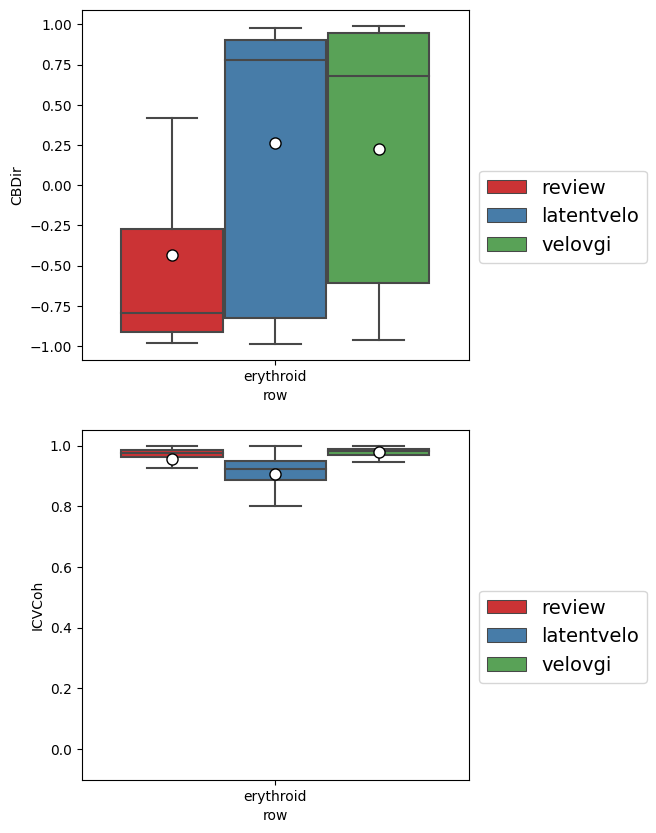

In [9]:
cluster_edges = [
    ("Blood progenitors 1", "Blood progenitors 2"), 
    ("Blood progenitors 2", "Erythroid1"), 
    ("Erythroid1", "Erythroid2"), 
    ("Erythroid2", "Erythroid3")
    ] # 已知的细胞类型间的分化信息

model_names = ["review_erythroid", "latentvelo_erythroid", "velovgi_erythroid"] # 指标结果名称遵循特定的规则：模型_数据
adata_list = [adata_review, adata_latentvelo, adata]

df = velovgi.tl.get_metric_total_df(model_names, adata_list, cluster_edges, cluster_key) # 指标计算
velovgi.pl.plot_metric_total_df(df) # 指标绘制

## 3. 图结构展示

1. 弦图

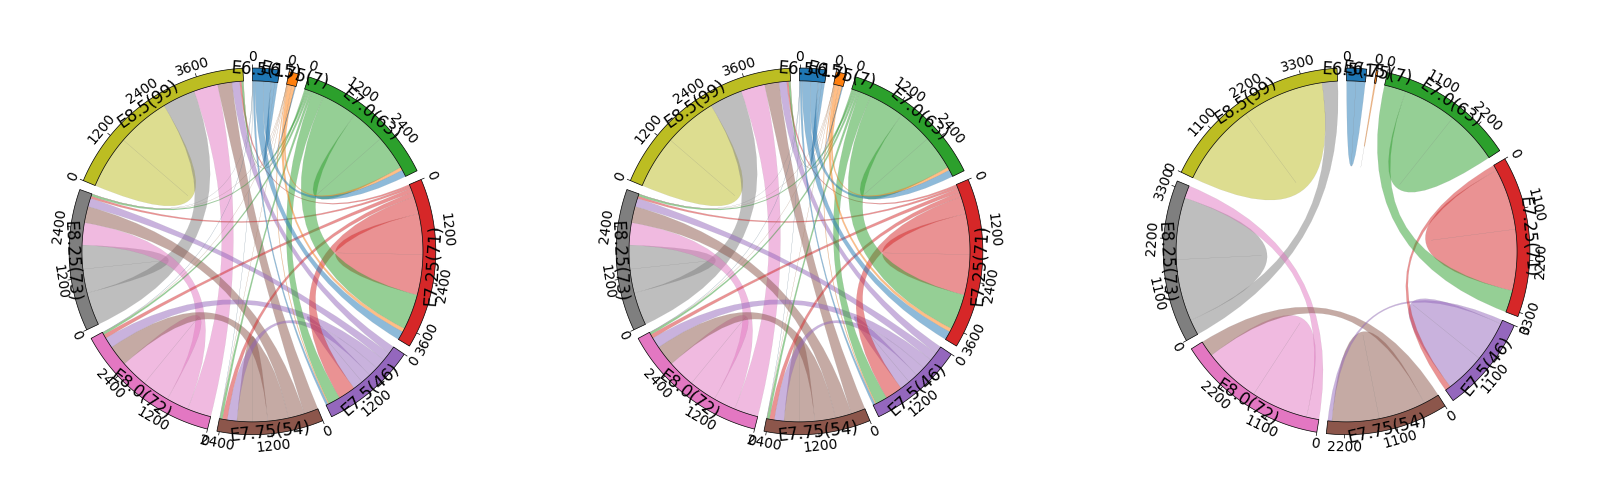

In [11]:
circos_fig, circos_ax = plt.subplots(1, 3, figsize=(20,5), subplot_kw=dict(projection="polar")) # 弦图


velovgi.pl.draw_batch_circos_ax(adata_review, batch_key=batch_key, ax=circos_ax[0])
velovgi.pl.draw_batch_circos_ax(adata_latentvelo, batch_key=batch_key, ax=circos_ax[1])
velovgi.pl.draw_batch_circos_ax(adata, batch_key=batch_key, ax=circos_ax[2])

2. 邻居个数图

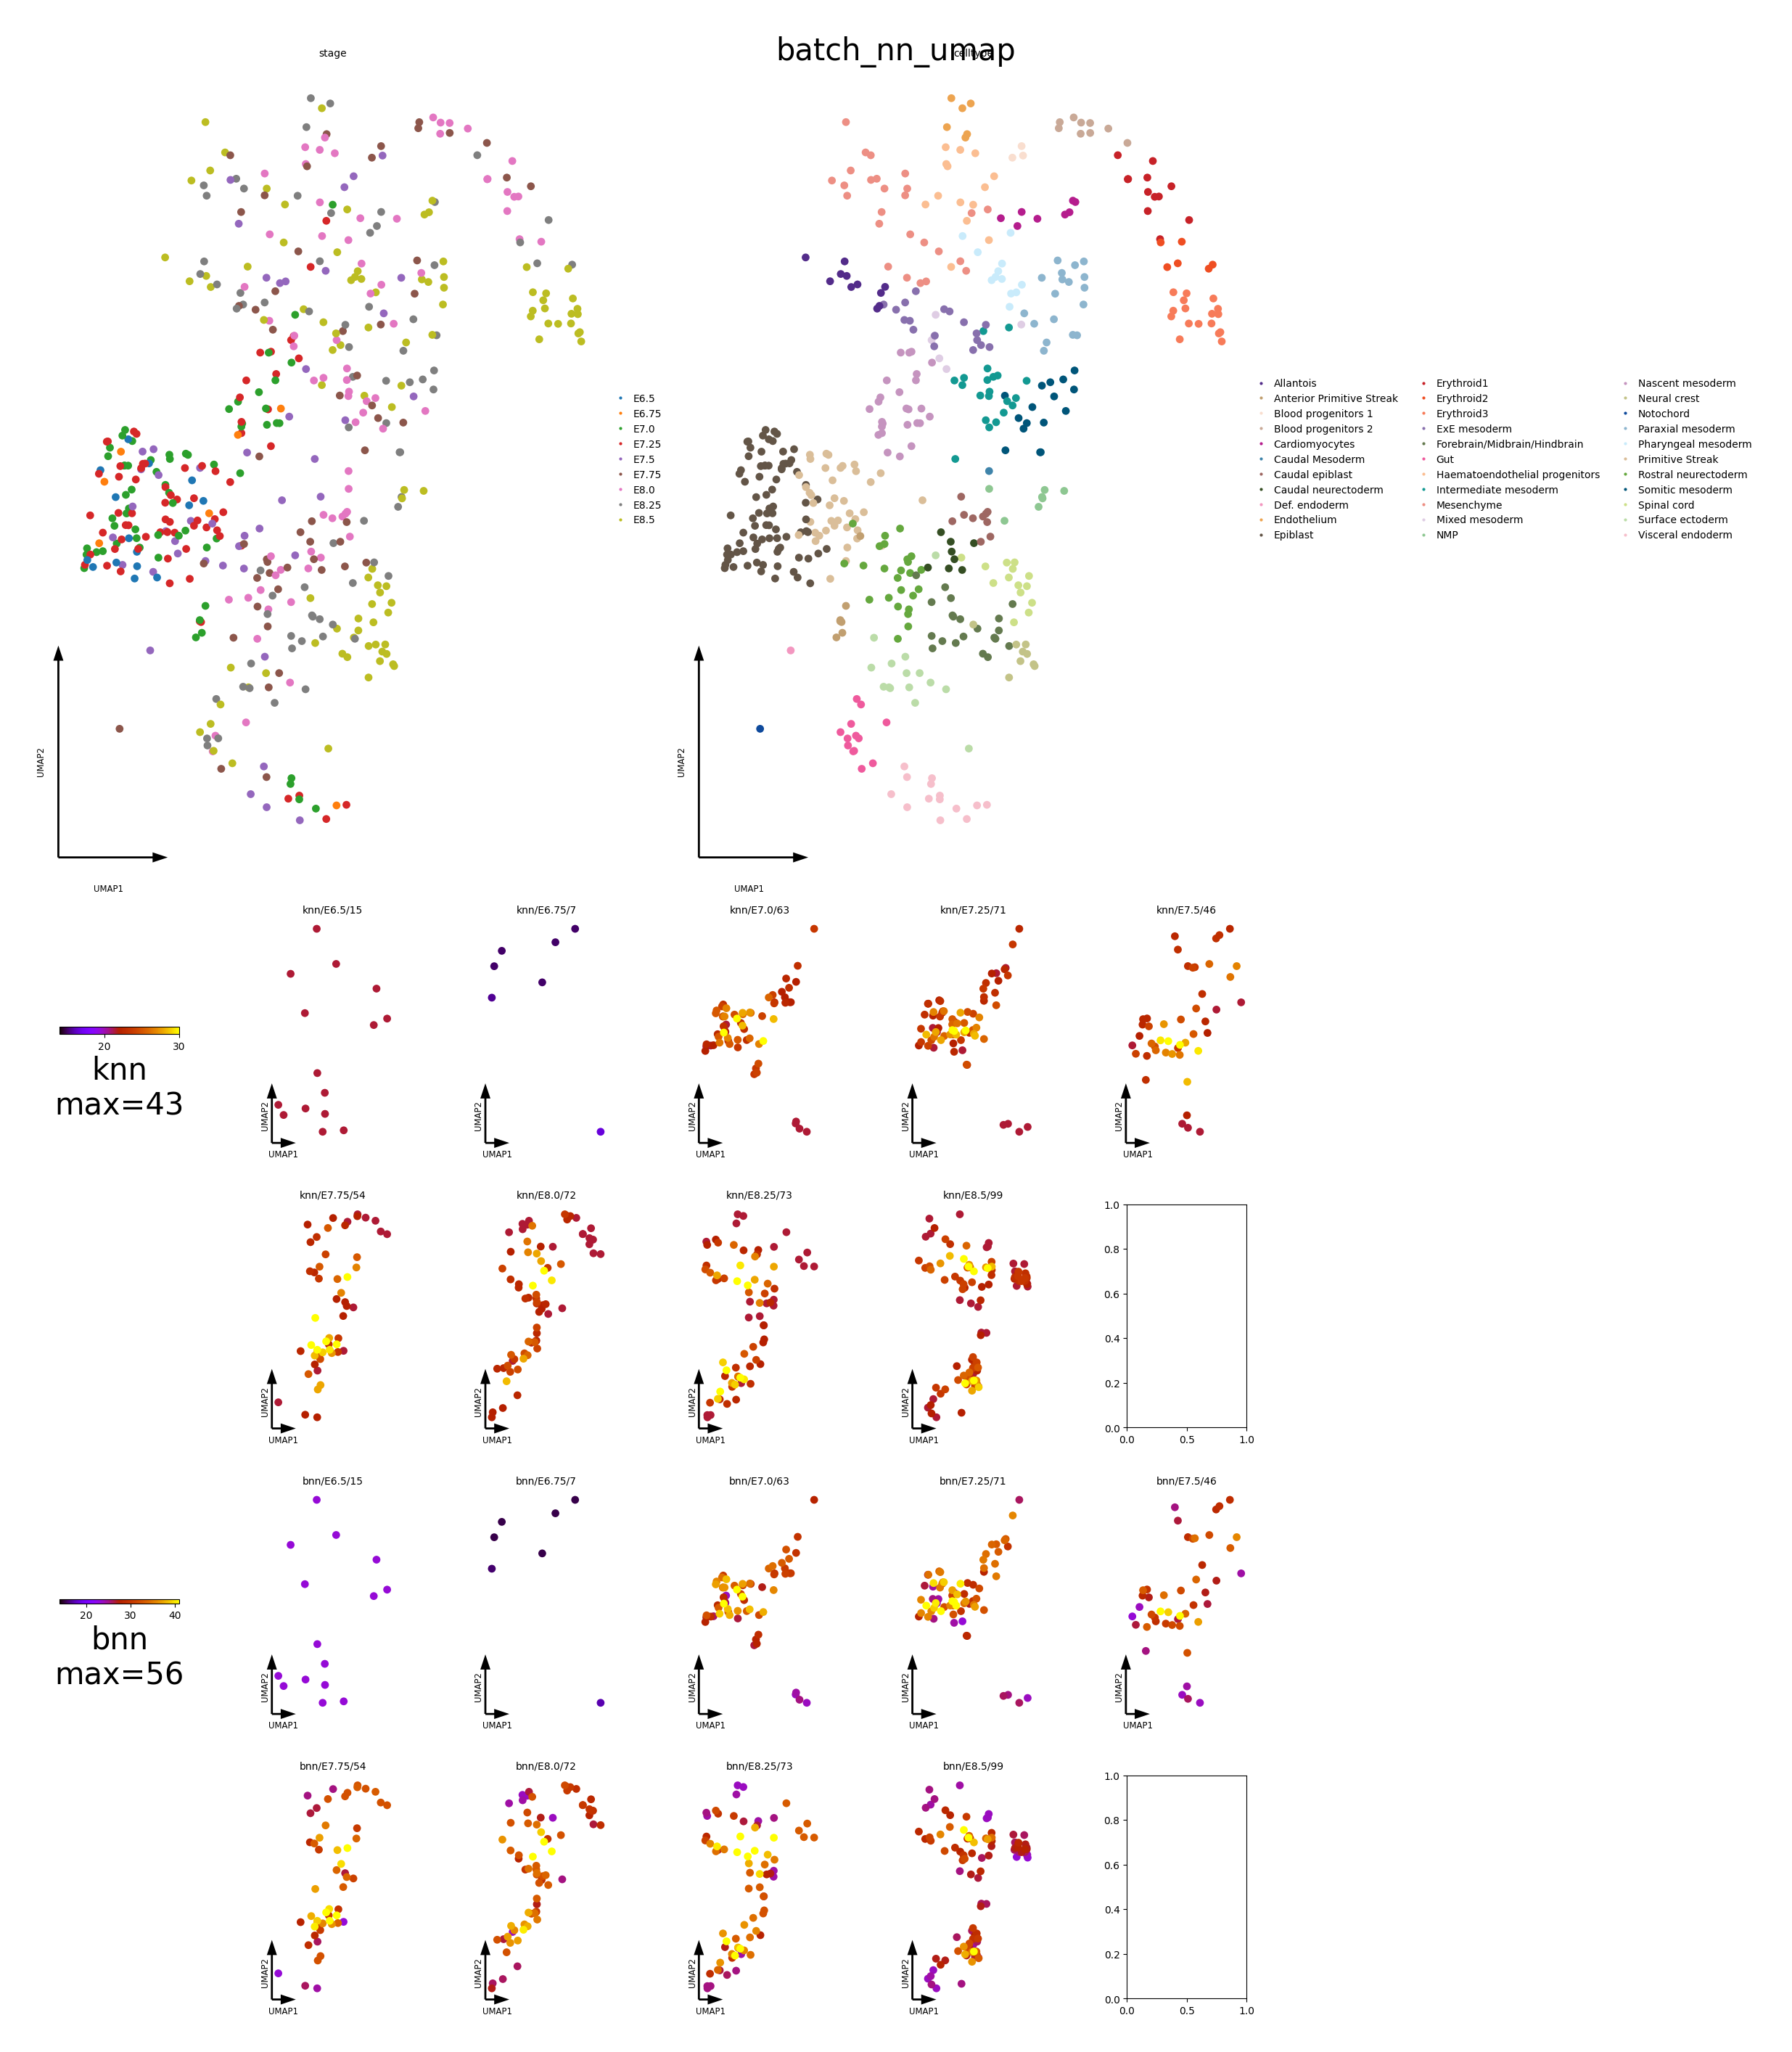

In [12]:
velovgi.pl.draw_batch_nn_umap(adata, batch_key=batch_key, cluster_key=cluster_key, save="tmp2.jpg")

## 4. 基因速率的查看

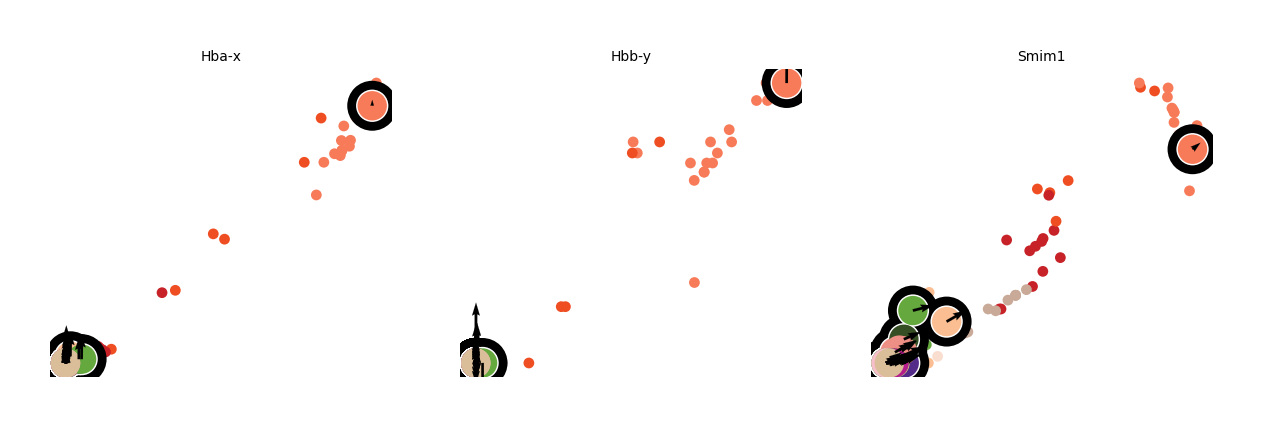

In [13]:
gene_list = ["Hba-x", "Hbb-y", "Smim1"]

velovgi.pl.draw_velocity_gene_list(adata, gene_list, cluster_key=cluster_key, cols=5)

## 5. 速率的伪时间查看

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


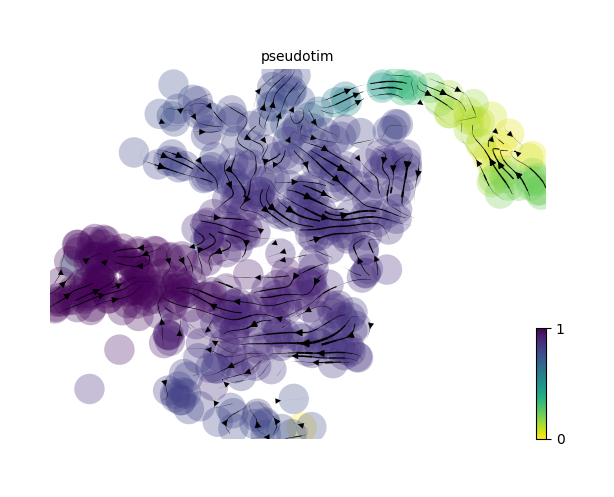

In [14]:
scv.tl.velocity_pseudotime(adata) # 速率的伪时间计算
scv.pl.velocity_embedding_stream(adata, color="velocity_pseudotime", title="pseudotim")